In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #input -? OUtput? RF
#         self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
#         self.pool1 = nn.MaxPool2d(2, 2)
#         self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
#         self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
#         self.pool2 = nn.MaxPool2d(2, 2)
#         self.conv5 = nn.Conv2d(256, 512, 3)
#         self.conv6 = nn.Conv2d(512, 1024, 3)
#         self.conv7 = nn.Conv2d(1024, 10, 3)

#     def forward(self, x):
#         x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
#         x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
#         x = F.relu(self.conv6(F.relu(self.conv5(x))))
#         # x = F.relu(self.conv7(x))
#         x = self.conv7(x)
#         x = x.view(-1, 10)
#         return F.log_softmax(x, dim=-1)

In [0]:
# !pip install torchsummary
# from torchsummary import summary
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# model = Net().to(device)
# summary(model, input_size=(1, 28, 28))

The above model has 6.3 million parameters. It is quiet a heavy model. 

In [7]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10), nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 26, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 24, RF = 5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20), nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 22, RF = 7

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11, RF = 8
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10), nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 11, RF = 8

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10), nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 9, RF = 12
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20), nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 7, RF = 16

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20), nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 7, RF = 20
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5) # output_size = 1, RF = 28
        )
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1, RF = 28

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 20)
        return F.log_softmax(x, dim=-1)

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
           Dropout-3           [-1, 10, 26, 26]               0
              ReLU-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
           Dropout-7           [-1, 10, 24, 24]               0
              ReLU-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 20, 22, 22]           1,800
      BatchNorm2d-10           [-1, 20, 22, 22]              40
          Dropout-11           [-1, 20, 22, 22]               0
             ReLU-12           [-1, 20, 22, 22]               0
        MaxPool2d-13           [-1, 20, 11, 11]               0
           Conv2d-14           [-1, 10,

The above model is less than 10k parameters

In [9]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [10]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


loss=0.14186622202396393 batch_id=468 Accuracy=80.31: 100%|██████████| 469/469 [00:17<00:00, 26.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1142, Accuracy: 9720/10000 (97%)

EPOCH: 1


loss=0.21583223342895508 batch_id=468 Accuracy=96.69: 100%|██████████| 469/469 [00:17<00:00, 26.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0685, Accuracy: 9816/10000 (98%)

EPOCH: 2


loss=0.03582313284277916 batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:17<00:00, 26.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0543, Accuracy: 9840/10000 (98%)

EPOCH: 3


loss=0.024476394057273865 batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:17<00:00, 26.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0595, Accuracy: 9817/10000 (98%)

EPOCH: 4


loss=0.036777663975954056 batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:17<00:00, 26.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0446, Accuracy: 9868/10000 (99%)

EPOCH: 5


loss=0.04879206791520119 batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:17<00:00, 27.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9904/10000 (99%)

EPOCH: 6


loss=0.04376071318984032 batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:17<00:00, 26.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 9892/10000 (99%)

EPOCH: 7


loss=0.046972110867500305 batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:17<00:00, 26.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9907/10000 (99%)

EPOCH: 8


loss=0.019826790317893028 batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:17<00:00, 27.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9903/10000 (99%)

EPOCH: 9


loss=0.09794866293668747 batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:17<00:00, 26.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Accuracy: 9885/10000 (99%)

EPOCH: 10


loss=0.05962083861231804 batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:17<00:00, 26.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9904/10000 (99%)

EPOCH: 11


loss=0.03220599517226219 batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:17<00:00, 26.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9907/10000 (99%)

EPOCH: 12


loss=0.01155050564557314 batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:17<00:00, 26.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9910/10000 (99%)

EPOCH: 13


loss=0.011747737415134907 batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:17<00:00, 27.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9927/10000 (99%)

EPOCH: 14


loss=0.01178690791130066 batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:17<00:00, 26.63it/s]



Test set: Average loss: 0.0304, Accuracy: 9907/10000 (99%)



Target: To fine-tune the model further by adding LR Scheduler and Image augmentation.

Result: Achieved a maximum accuarcy of around 99.27%..

Analysis: The accuracy is still short of 99.4% and has to be consistent for the last few epochs.
 Looks like the model is underfitting


Text(0.5, 1.0, 'Test Accuracy')

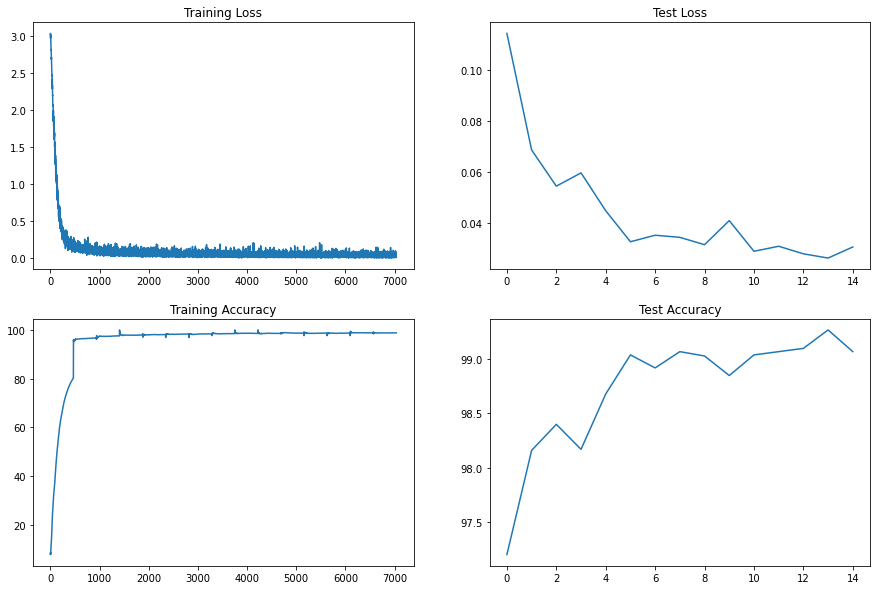

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")